# Predicting Match Outcomes in Dota 2



- Student Name: John Casey Dean
- Student Pace: Part Time
- Scheduled Review: 1-8-2021 16:30 CT
- Instructor Name: Lindsey Berlin
- Blog Post URL: 

# Introduction

For the better part of two decades, online multiplayer video games have been accruing massive player bases and forming competitive environments within them. These games span many different genres, and range from simple enough for children to complex enough to require thousands of hours of playtime to develop high level skills. 

One such game is Dota 2, created by Valve Software. Launched in 2012, this game has maintained a strong following all the way to the present day, where there are at least 400,000 players online at any point in time. Given the stability of the player base, it's not surprising that it also enjoys a strong competitive scene, creating myriad opportunities for individuals to generate income from the game. It has also generated an appetite for strong predictive tools that allow for more confident analysis and betting predictions.

This project seeks to develop a strong predictive model for win probabilities of two teams, using only what is known prior to the start of a match.

# Obtaining Data

This project uses data sourced from OpenDota, an open source community project that parses match data from Steam and provided the parsed match data to users. You can find the OpenDota project here: https://www.opendota.com/ 

Using their API, we pulled nearly 32,000 random matches from January 1, 2021, to January 4, 2021, and used them to build our models.

# Scrubbing the Data

The data we obtained contains everything we need to make a minimum viable product, but the formatting is incovenient for exploration and modeling. Before moving on, the data will need to be reformatted.

## Importing Necessary Libraries and Data

In [4]:
import pandas as pd
import seaborn as sns
import requests
import json
import sklearn
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from project_funcs import add_hero_cols, plot_conf_matrix, plot_roc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import plot_confusion_matrix,roc_curve, confusion_matrix 
from sklearn.metrics import plot_roc_curve, roc_curve
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
import pickle

In [5]:
df = pd.read_csv('match_data.csv')
df.head()

,match_id,match_seq_num,radiant_win,start_time,duration,avg_mmr,num_mmr,lobby_type,game_mode,avg_rank_tier,num_rank_tier,cluster,radiant_team,dire_team
0,5774382508,4861536209,True,1609928270,567,4902.0,6.0,7,3,79,8,236,"81,62,41,39,31","95,8,1,129,109"
1,5774380902,4861534174,True,1609928176,448,NaN,NaN,0,22,25,3,184,"18,2,21,37,84","62,13,35,41,4"
2,5774380304,4861533616,True,1609928140,474,3978.0,1.0,0,22,54,3,187,"30,123,65,70,50","42,19,59,90,86"
3,5774378001,4861541478,False,1609928009,1192,NaN,NaN,0,22,27,3,134,"93,74,120,42,52","121,99,77,21,101"
4,5774376916,4861542219,False,1609927939,1312,2531.0,2.0,0,4,42,5,137,"44,30,17,8,110","35,75,32,59,27"


In [6]:
df.isna().sum()

match_id            0
match_seq_num       0
radiant_win         0
start_time          0
duration            0
avg_mmr          7087
num_mmr          7087
lobby_type          0
game_mode           0
avg_rank_tier       0
num_rank_tier       0
cluster             0
radiant_team        0
dire_team           0
dtype: int64

In [7]:
df.shape

(31934, 14)

Most Dota 2 matches fall under two "lobby types", ranked and normal. The PublicMatches response for the OpenDota API should only return matches that fall under these two types. In the json file, the lobby type is denoted by an integer. In this case, 7 denotes a ranked lobby, whereas 0 denotes a normal lobby. As long as all of our matches are one of these two types, we can keep them.

In [8]:
df['lobby_type'].value_counts()

7    25783
0     6151
Name: lobby_type, dtype: int64

The API pull should also return only "balanced" game modes, meaning games that use MMR to determine players on each team and thus should be fair matches. Again, we can see here that we recieved only balanced game modes.

In [9]:
df['game_mode'].value_counts()

22    26954
3      2643
4      2307
5        30
Name: game_mode, dtype: int64

We know from both thousands of hours of playtime and other raw data resources that skill level matters in determining which teams will win, with heroes performing differently in different skill brackets. Queen of Pain, for example, historically performs well in low skill brackets, but her win rate falls off in higher brackets, while a hero like Chen tends to perform poorly in low skill matches but shows a higher win rate in high skill matches. Knowing this, we have decided to only keep matches that have some mmr listed, and to keep the "avg_mmr" feature for modeling. Our Logistic Regression may not pick up on these interactions well, but our random forest and any other models should be able to make the connections where it is relevant.

In [10]:
df['num_mmr'].value_counts()

1.0    7777
2.0    7065
3.0    5386
4.0    2814
5.0    1158
6.0     555
7.0      92
Name: num_mmr, dtype: int64

In [11]:
df = df.dropna()

In [12]:
df.isna().sum()

match_id         0
match_seq_num    0
radiant_win      0
start_time       0
duration         0
avg_mmr          0
num_mmr          0
lobby_type       0
game_mode        0
avg_rank_tier    0
num_rank_tier    0
cluster          0
radiant_team     0
dire_team        0
dtype: int64

### Why did we chose this format?
The data returned from the API contains strings with numbers for each team. In order to make the team compositions useful for models, we need to reformat these features. For this project, our approach is to effectively create a sparse table containing columns for each hero on dire side and additional columns for each hero on radiant. The hope is that formatting this way will allow our models to pick up on interactions such as counter picks, such as picking Puck as a counter to Pangolier, or Earthshaker to counter a Phantom Lancer. An alternative that was considered was placing all teams in the same colummns, which would effectively double our observations and cut our features in half. We chose not to go this route because it would not allow for interactions of counter picks.

In [13]:
df2 = add_hero_cols(df, 'radiant_team') #calling our function to break hero teams into meaninful features through one-hot encoding
df2 = add_hero_cols(df, 'dire_team')
df2.head()

,match_id,match_seq_num,radiant_win,start_time,duration,avg_mmr,num_mmr,lobby_type,game_mode,avg_rank_tier,...,Winter Wyvern_dire_team,Arc Warden_dire_team,Monkey King_dire_team,Dark Willow_dire_team,Pangolier_dire_team,Grimstroke_dire_team,Hoodwink_dire_team,Void Spirit_dire_team,Snapfire_dire_team,Mars_dire_team
0,5774382508,4861536209,True,1609928270,567,4902.0,6.0,7,3,79,...,0,0,0,0,0,0,0,0,0,1
2,5774380304,4861533616,True,1609928140,474,3978.0,1.0,0,22,54,...,0,0,0,0,0,0,0,0,0,0
4,5774376916,4861542219,False,1609927939,1312,2531.0,2.0,0,4,42,...,0,0,0,0,0,0,0,0,0,0
5,5774376511,4861538645,True,1609927915,1070,2362.0,3.0,7,22,53,...,0,0,0,0,0,0,0,0,0,0
6,5774375502,4861539678,True,1609927840,1247,3593.0,1.0,7,22,32,...,0,0,0,0,0,1,0,0,0,0


In [14]:
#dropping unnecessary features from our data set
df2.drop(['match_id', 'match_seq_num', 'start_time', 'duration', 'num_mmr',
          'lobby_type', 'game_mode', 'avg_rank_tier', 'num_rank_tier', 'cluster'], 
         axis = 1, inplace = True)
df2.head()

,radiant_win,avg_mmr,Anti-Mage_radiant_team,Axe_radiant_team,Bane_radiant_team,Bloodseeker_radiant_team,Crystal Maiden_radiant_team,Drow Ranger_radiant_team,Earthshaker_radiant_team,Juggernaut_radiant_team,...,Winter Wyvern_dire_team,Arc Warden_dire_team,Monkey King_dire_team,Dark Willow_dire_team,Pangolier_dire_team,Grimstroke_dire_team,Hoodwink_dire_team,Void Spirit_dire_team,Snapfire_dire_team,Mars_dire_team
0,True,4902.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,True,3978.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,False,2531.0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,True,2362.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,True,3593.0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


In [15]:
df2.to_csv('sparse_table.csv', index = False) #exporting the cleaned table for use in further analysis as well as in deployment of a web app

In [16]:
df2['radiant_win'].value_counts() #cheking the class balance of our data

True     15333
False     9514
Name: radiant_win, dtype: int64

# Exploratory Data Analysis

In [17]:
heroes = requests.get('https://api.opendota.com/api/constants/heroes')
heroes = heroes.json()

for hero in heroes :
    heroes['{}'.format(hero)]['localized_name'].replace(' ', '_')
    
heroes

{'1': {'id': 1,
  'name': 'npc_dota_hero_antimage',
  'localized_name': 'Anti-Mage',
  'primary_attr': 'agi',
  'attack_type': 'Melee',
  'roles': ['Carry', 'Escape', 'Nuker'],
  'img': '/apps/dota2/images/heroes/antimage_full.png?',
  'icon': '/apps/dota2/images/heroes/antimage_icon.png',
  'base_health': 200,
  'base_health_regen': 0.25,
  'base_mana': 75,
  'base_mana_regen': 0,
  'base_armor': -1,
  'base_mr': 25,
  'base_attack_min': 29,
  'base_attack_max': 33,
  'base_str': 23,
  'base_agi': 24,
  'base_int': 12,
  'str_gain': 1.3,
  'agi_gain': 2.8,
  'int_gain': 1.8,
  'attack_range': 150,
  'projectile_speed': 0,
  'attack_rate': 1.4,
  'move_speed': 310,
  'turn_rate': 0.5,
  'cm_enabled': True,
  'legs': 2},
 '2': {'id': 2,
  'name': 'npc_dota_hero_axe',
  'localized_name': 'Axe',
  'primary_attr': 'str',
  'attack_type': 'Melee',
  'roles': ['Initiator', 'Durable', 'Disabler', 'Jungler'],
  'img': '/apps/dota2/images/heroes/axe_full.png?',
  'icon': '/apps/dota2/images/her

This next cell may look a little confusing, but it's necessary due to a quirk in how Dota 2 heroes are identified in the Steam API, and thus the OPenDota API. The reference for heroes skips several numbers, including 24, 116-119, and a couple of others. This code allows us to compile a dictionary of stats while working around this quirk to avoid unnecessary blank spaces in our eventual table.

In [18]:
game_stats = {'hero' : [], 'games' : [], 'wins' : []}
for i in range(1, 23, 1):
    total_games = df2.iloc[:,i+1].sum() + df2.iloc[:,i+121].sum()
    hero_radiant_wins = sum(df2['radiant_win'] & df2.iloc[:,i+1])
    hero_dire_wins = sum(df2['radiant_win'] & df2.iloc[:,i+121])
    wins =  hero_radiant_wins + hero_dire_wins
    game_stats['hero'].append('{}'.format(heroes['{}'.format(i)]['localized_name']))
    game_stats['games'].append(total_games)
    game_stats['wins'].append(wins)
    
for i in range(25, 114, 1):
    total_games = df2.iloc[:,i].sum() + df2.iloc[:,i+120].sum()
    hero_radiant_wins = sum(df2['radiant_win'] & df2.iloc[:,i])
    hero_dire_wins = sum(df2['radiant_win'] & df2.iloc[:,i+120])
    wins =  hero_radiant_wins + hero_dire_wins
    game_stats['hero'].append('{}'.format(heroes['{}'.format(i)]['localized_name']))
    game_stats['games'].append(total_games)
    game_stats['wins'].append(wins)

for i in range(119, 121, 1):
    total_games = df2.iloc[:,i-4].sum() + df2.iloc[:,i+117].sum()
    hero_radiant_wins = sum(df2['radiant_win'] & df2.iloc[:,i-4])
    hero_dire_wins = sum(df2['radiant_win'] & df2.iloc[:,i+117])
    wins =  hero_radiant_wins + hero_dire_wins
    game_stats['hero'].append('{}'.format(heroes['{}'.format(i)]['localized_name']))
    game_stats['games'].append(total_games)
    game_stats['wins'].append(wins)

total_games = df2.iloc[:,118].sum() + df2.iloc[:,118+120].sum()
hero_radiant_wins = sum(df2['radiant_win'] & df2.iloc[:,118])
hero_dire_wins = sum(df2['radiant_win'] & df2.iloc[:,118+120])
wins =  hero_radiant_wins + hero_dire_wins
game_stats['hero'].append('{}'.format(heroes['{}'.format(123)]['localized_name']))
game_stats['games'].append(total_games)
game_stats['wins'].append(wins)
    
total_games = df2.iloc[:,119].sum() + df2.iloc[:,119+120].sum()
hero_radiant_wins = sum(df2['radiant_win'] & df2.iloc[:,119])
hero_dire_wins = sum(df2['radiant_win'] & df2.iloc[:,119+120])
wins =  hero_radiant_wins + hero_dire_wins
game_stats['hero'].append('{}'.format(heroes['{}'.format(126)]['localized_name']))
game_stats['games'].append(total_games)
game_stats['wins'].append(wins)

total_games = df2.iloc[:,120].sum() + df2.iloc[:,120+120].sum()
hero_radiant_wins = sum(df2['radiant_win'] & df2.iloc[:,120])
hero_dire_wins = sum(df2['radiant_win'] & df2.iloc[:,120+120])
wins =  hero_radiant_wins + hero_dire_wins
game_stats['hero'].append('{}'.format(heroes['{}'.format(128)]['localized_name']))
game_stats['games'].append(total_games)
game_stats['wins'].append(wins)

total_games = df2.iloc[:,121].sum() + df2.iloc[:,121+120].sum()
hero_radiant_wins = sum(df2['radiant_win'] & df2.iloc[:,121])
hero_dire_wins = sum(df2['radiant_win'] & df2.iloc[:,121+120])
wins =  hero_radiant_wins + hero_dire_wins
game_stats['hero'].append('{}'.format(heroes['{}'.format(129)]['localized_name']))
game_stats['games'].append(total_games)
game_stats['wins'].append(wins)

game_stats
    

{'hero': ['Anti-Mage',
  'Axe',
  'Bane',
  'Bloodseeker',
  'Crystal Maiden',
  'Drow Ranger',
  'Earthshaker',
  'Juggernaut',
  'Mirana',
  'Morphling',
  'Shadow Fiend',
  'Phantom Lancer',
  'Puck',
  'Pudge',
  'Razor',
  'Sand King',
  'Storm Spirit',
  'Sven',
  'Tiny',
  'Vengeful Spirit',
  'Windranger',
  'Zeus',
  'Lina',
  'Lion',
  'Shadow Shaman',
  'Slardar',
  'Tidehunter',
  'Witch Doctor',
  'Lich',
  'Riki',
  'Enigma',
  'Tinker',
  'Sniper',
  'Necrophos',
  'Warlock',
  'Beastmaster',
  'Queen of Pain',
  'Venomancer',
  'Faceless Void',
  'Wraith King',
  'Death Prophet',
  'Phantom Assassin',
  'Pugna',
  'Templar Assassin',
  'Viper',
  'Luna',
  'Dragon Knight',
  'Dazzle',
  'Clockwerk',
  'Leshrac',
  "Nature's Prophet",
  'Lifestealer',
  'Dark Seer',
  'Clinkz',
  'Omniknight',
  'Enchantress',
  'Huskar',
  'Night Stalker',
  'Broodmother',
  'Bounty Hunter',
  'Weaver',
  'Jakiro',
  'Batrider',
  'Chen',
  'Spectre',
  'Ancient Apparition',
  'Doom',
 

In [19]:
stat_df = pd.DataFrame(game_stats)
stat_df.head()

,hero,games,wins
0,Anti-Mage,3692,2227
1,Axe,2533,1607
2,Bane,1527,968
3,Bloodseeker,808,480
4,Crystal Maiden,3417,2034


In [25]:
stat_df = stat_df.sort_values(['games'], ascending=False).reset_index(drop=True)

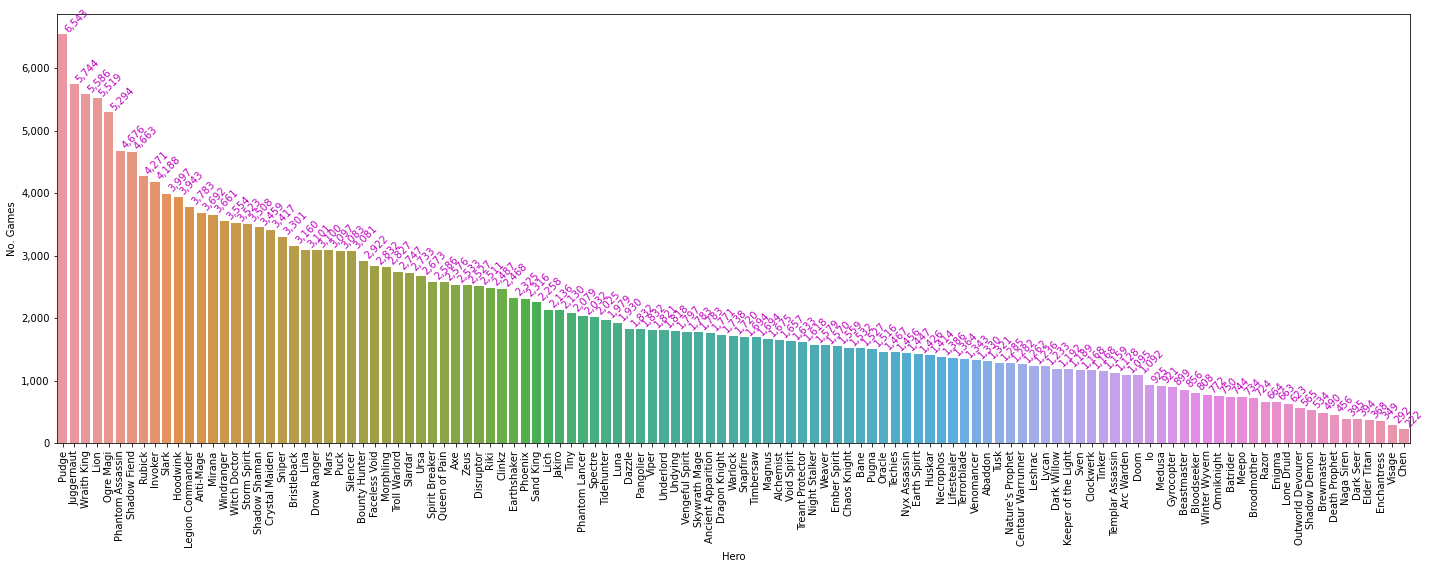

In [29]:
plt.figure(figsize=(20,8))
# plot barh chart with index as x values
ax = sns.barplot(stat_df.hero, stat_df.games)
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax.set(xlabel="Hero", ylabel='No. Games')
# add proper Heroes as x labels
ax.set_xticklabels(stat_df.hero)
for item in ax.get_xticklabels(): item.set_rotation(90)
for i, v in enumerate(stat_df["games"].iteritems()):        
    ax.text(i ,v[1], "{:,}".format(v[1]), color='m', va ='bottom', rotation=45)
plt.tight_layout()
plt.show()

As you can see, heroes are not selecting evenly across matches. Some heroes, such as Chen or Elder Titan, are avoided by many players because of how difficult they are to play. Others see swings in popularity based on their strength in recent patches, which explains why a hero like Enchantress has such a low representation at the moment despite being on of the games favorite characters. Other heroes are just very stable and safe selections and therefore show up in matches more frequently regardless, such as Juggernaut or Ogre Magi. This could cause our model to overvalue heroes with low representation that performed particularly well when picked, or to possibly undervalue heroes that are picked more frequently and have win percentages closer to 50%. An alternative approach we could have used would be to gather some number of matches with each unique combination of heroes, but for the sake of time and autheticity we chose to take this approach with our first pass.

Now, while this is a very pretty graph with some useful information, but let's add in win percentages and focus in on some more specific subsets of heroes.

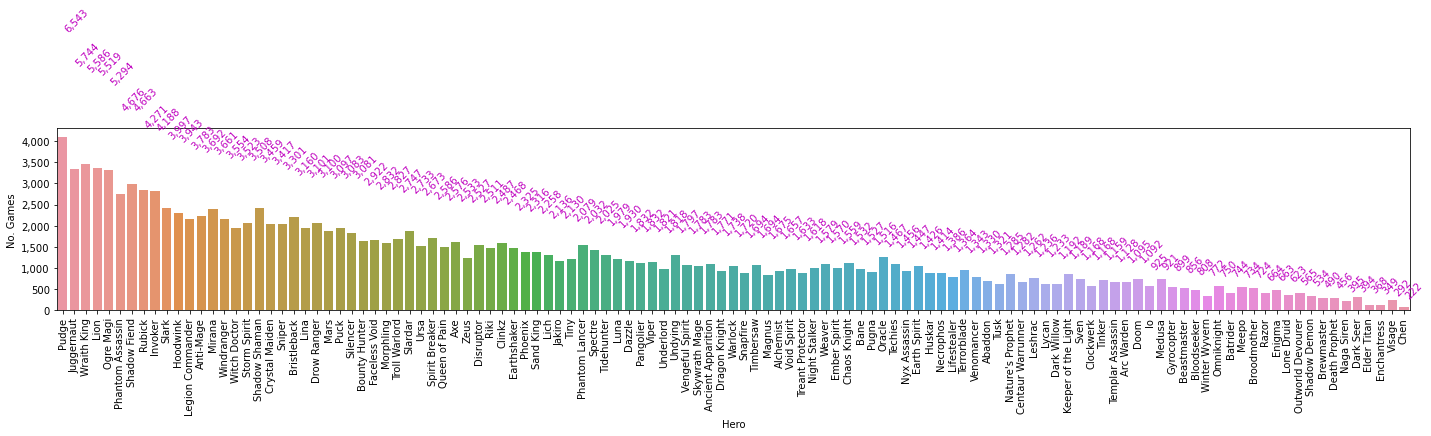

In [31]:
plt.figure(figsize=(20,8))
# plot barh chart with index as x values
ax = sns.barplot(stat_df.hero, stat_df.wins)
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax.set(xlabel="Hero", ylabel='No. Games')
# add proper Heroes as x labels
ax.set_xticklabels(stat_df.hero)
for item in ax.get_xticklabels(): item.set_rotation(90)
for i, v in enumerate(stat_df["games"].iteritems()):        
    ax.text(i ,v[1], "{:,}".format(v[1]), color='m', va ='bottom', rotation=45)
plt.tight_layout()
plt.show()

# Modeling

The first model we will create is a simple logistic regression model. This will give us a baseline to compare other models to. We will then explore other models, including boosting and parameter tuning packages. 

Before actually modeling, we have a single column that outscales the others drastically; the avg_mmr feature. In order to avoid overtuning to this feature, we will quickly scale it down between 0 and 1 to be in line with our sparse table.

In [34]:
mmr_max = df2['avg_mmr'].max()

In [35]:
df2['avg_mmr'] = df2['avg_mmr']/mmr_max
df2.head()

,radiant_win,avg_mmr,Anti-Mage_radiant_team,Axe_radiant_team,Bane_radiant_team,Bloodseeker_radiant_team,Crystal Maiden_radiant_team,Drow Ranger_radiant_team,Earthshaker_radiant_team,Juggernaut_radiant_team,...,Winter Wyvern_dire_team,Arc Warden_dire_team,Monkey King_dire_team,Dark Willow_dire_team,Pangolier_dire_team,Grimstroke_dire_team,Hoodwink_dire_team,Void Spirit_dire_team,Snapfire_dire_team,Mars_dire_team
0,True,0.750000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,True,0.608629,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,False,0.387240,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,True,0.361383,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,True,0.549725,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


<AxesSubplot:xlabel='avg_mmr'>

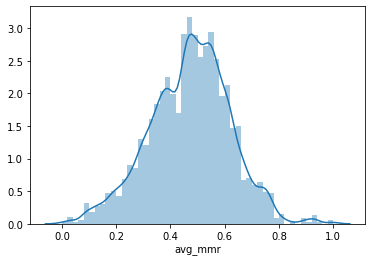

In [36]:
sns.distplot(df2['avg_mmr']) #checking to ensure our mmr distribution appears normal

In [37]:
state = 117

In [38]:
# Separating our features from our target
df2_x = df2.drop(columns=['radiant_win'], axis = 1)
df2_y = df2['radiant_win']

In [39]:
# Generating training and testing data
x_train, x_test, y_train, y_test = train_test_split(df2_x, df2_y, test_size = 0.25, random_state=state)

## Logistic Regression

In [40]:
# Instantiating our estimator object
logreg = LogisticRegression(max_iter = 200, random_state = state, solver ='lbfgs',  n_jobs=-1)

In [41]:
# Fitting our model
logreg.fit(x_train, y_train)

LogisticRegression(max_iter=200, n_jobs=-1, random_state=117)

In [42]:
# Generating our predictions
lr_predictions = logreg.predict(x_test)

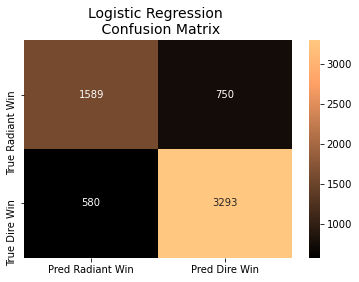

In [43]:
# Generate an plot our confusion matrix
plot_conf_matrix('Logistic Regression', lr_predictions, y_test)

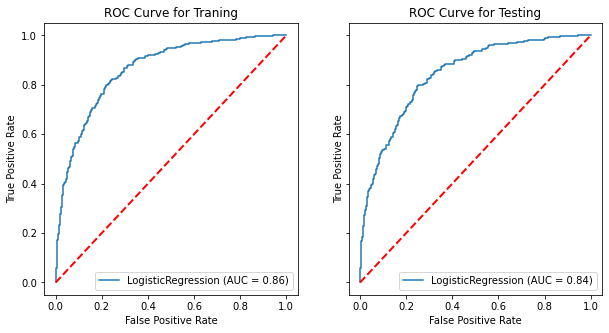

In [44]:
plot_roc(logreg, x_train, y_train, x_test, y_test)

## Random Forest Classifier

In [45]:
# Instantiating our estimator object
rfc = RandomForestClassifier(criterion='entropy',
                             min_samples_split=.1,
                             random_state=state,
                             n_jobs=-1)

In [46]:
rfc.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', min_samples_split=0.1, n_jobs=-1,
                       random_state=117)

In [47]:
rfc_y_pred = rfc.predict(x_test)

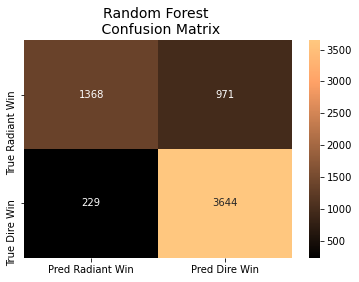

In [48]:
# Generate an plot our confusion matrix
plot_conf_matrix('Random Forest', rfc_y_pred, y_test)

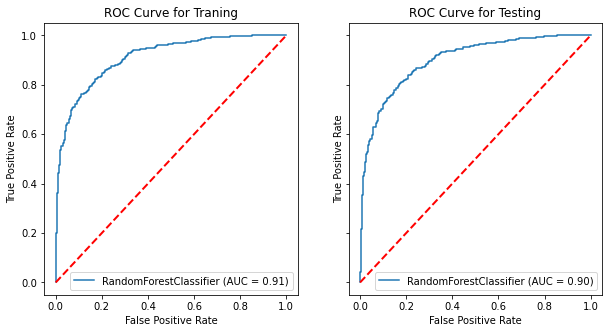

In [49]:
plot_roc(rfc, x_train, y_train, x_test, y_test)

## GridsearchCV

In [50]:
# Create first pipeline for base without reducing features.

pipe = Pipeline([('classifier' , RandomForestClassifier())])

# Create param grid.

param_grid = [
    {'classifier' : [LogisticRegression()],
    'classifier__penalty' : ['l1', 'l2'],
    'classifier__solver' : ['liblinear']},
    {'classifier' : [RandomForestClassifier()],
    'classifier__criterion' : ['entropy'],
    'classifier__min_samples_split' : [0.1, .01, .001],
    'classifier__max_features' : ['auto', 'sqrt', 'log2']
    }
]

# Create grid search object

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

# Fit on data

best_clf = clf.fit(x_train, y_train)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:   17.0s finished


In [51]:
gs_preds = best_clf.predict(x_test)

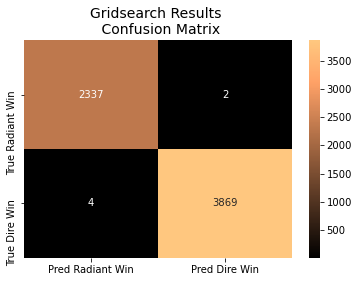

In [52]:
# Generate an plot our confusion matrix
plot_conf_matrix('Gridsearch Results', gs_preds, y_test)

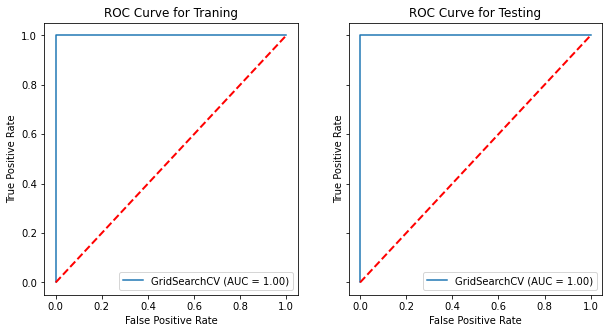

In [53]:
plot_roc(best_clf, x_train, y_train, x_test, y_test)

In [54]:
best_clf.best_params_

{'classifier': RandomForestClassifier(criterion='entropy', min_samples_split=0.001),
 'classifier__criterion': 'entropy',
 'classifier__max_features': 'auto',
 'classifier__min_samples_split': 0.001}

In [55]:
best_reg = RandomForestClassifier(criterion='entropy', 
                                  min_samples_split=0.001, 
                                  random_state = state, 
                                  n_jobs=-1)

In [56]:
final_clf = best_reg.fit(df2_x, df2_y)

# Future Work